In [13]:
import keras


# Cats and Dogs - image classification with a small training dataset

Problem and approach presented in this notebook is based on "Deep Learning with Python" by F. Chollet.

4000 pictures of cats and dogs (2000 cats, 2000 dogs). <br>
Use 2000, pictures for training, 1000 for validation and 1000 for testing.

- By using a small convnet we get 70% validation accuracy (overfitting!)
- By using *data augmentation*  we get an accuracy of 80%
- By using a *pre-trained network* we get an accuracy of 95%
- By using *fine-tuning a pre-trained network* we get 97%

## Downloading the data

- You can download the original dataset at: https://www.kaggle.com/c/dogs-vs-cats/data
- Small dataset: http://ki.pwr.edu.pl/lemiesz/info/cats_and_dogs_small.zip


## Building the model

We are dealing with bigger images and a  quite complex problem, <br>
so we use four `Conv2D` + `MaxPooling2D` stages. This increases <br>
the capacity of the network and reduce the size of the feature maps,  <br>
so that they not to big when they get to `Dense` layer.

Here, since we start from inputs of size 150x150 (an arbitrary choice),<br>
we end up with feature maps of size 7x7 right before the `Dense` layer.

Note that the depth of the feature maps is increasing  (from 32 to 128),<br>
while the size of the feature maps is decreasing (from 148x148 to 7x7).<br>
This is a typical pattern in convnets.

Since we are attacking a binary classification problem, we are ending the network <br>
with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation.

In [14]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),
                        activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [15]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

c:\Users\Gabriel\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Data preprocessing

* Read the picture files and convert into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

We can use the class `ImageDataGenerator` from Keras:

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'flowers/train'
validation_dir = 'flowers/validation'

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2162 images belonging to 5 classes.


Found 1078 images belonging to 5 classes.


Generator yields batches indefinitely - we need to `break` the iteration loop at some point.

In [17]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 5)


To fit the model we use `fit_generator` method, the equivalent of `fit` for data generators.
It expects as first argument a Python generator that will yield batches of inputs and targets.
Because the data is being generated endlessly, we need to to know  how many samples to draw  before declaring an epoch over (`steps_per_epoch`  argument).


In [18]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size)

Epoch 1/30


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_35232\3551954485.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


108/108 [==============================] - 5s 41ms/step - loss: 1.3989 - acc: 0.3834 - val_loss: 1.2177 - val_acc: 0.4592
Epoch 2/30
108/108 [==============================] - 4s 39ms/step - loss: 1.1906 - acc: 0.4986 - val_loss: 1.1492 - val_acc: 0.5204
Epoch 3/30
108/108 [==============================] - 4s 40ms/step - loss: 1.1281 - acc: 0.5324 - val_loss: 1.0926 - val_acc: 0.5343
Epoch 4/30
108/108 [==============================] - 4s 40ms/step - loss: 1.0588 - acc: 0.5740 - val_loss: 1.0744 - val_acc: 0.5659
Epoch 5/30
108/108 [==============================] - 4s 40ms/step - loss: 1.0194 - acc: 0.5870 - val_loss: 1.0138 - val_acc: 0.6020
Epoch 6/30
108/108 [==============================] - 4s 40ms/step - loss: 0.9572 - acc: 0.6267 - val_loss: 1.0348 - val_acc: 0.5844
Epoch 7/30
108/108 [==============================] - 4s 40ms/step - loss: 0.9092 - acc: 0.6503 - val_loss: 1.0049 - val_acc: 0.6141
Epoch 8/30
108/108 [==============================] - 4s 41ms/step - loss: 0.866

It is good practice to always save your models after training:

In [19]:
model.save('flowers_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

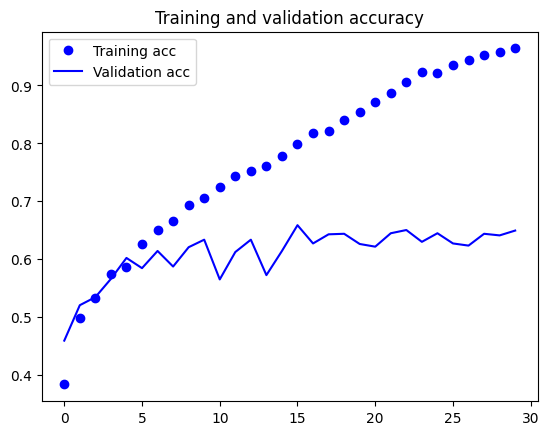

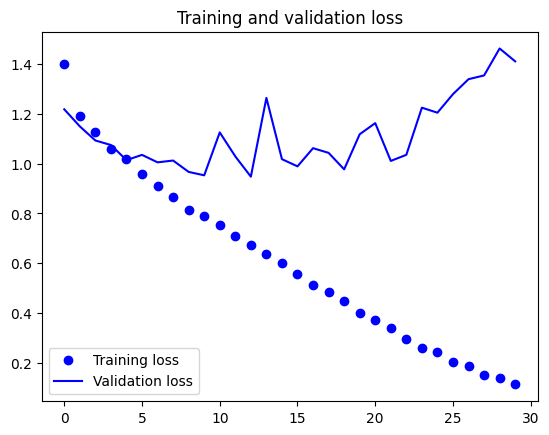

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Data augmentation




Overfitting is caused by having too few samples to learn from. <br>
Data augmentation process generates more training data from existing,<br>
by "augmenting" them via random transformations that give "believable" images.

In [21]:
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

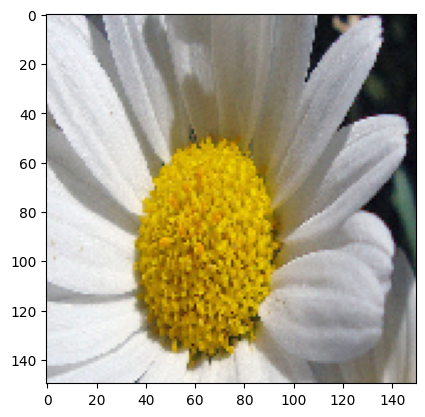

In [22]:
import os
# This is module with image preprocessing utilities
import keras.utils as image
import matplotlib.pyplot as plt

train_daisy_dir = 'flowers/train/daisy'
fnames = [os.path.join(train_daisy_dir, fname) for fname in os.listdir(train_daisy_dir)]

# We pick one image to "augment"
img_path = fnames[1]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

plt.imshow(img)

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)




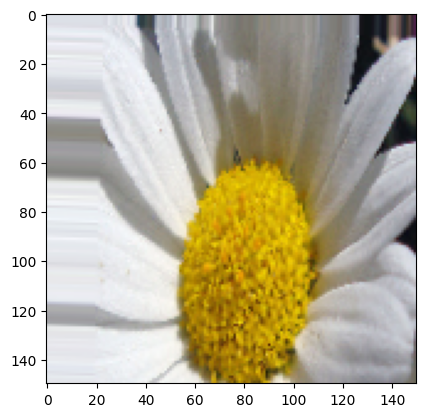

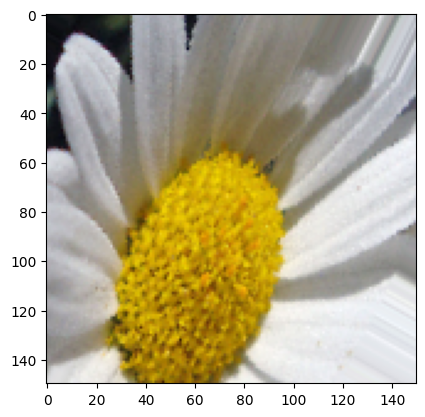

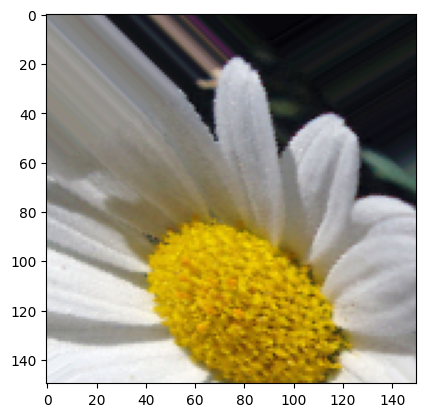

In [23]:
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break


If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information,
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

# Adding Dropout layer and data augmentation

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

c:\Users\Gabriel\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Let's train our network using data augmentation and dropout:

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size)

Found 2162 images belonging to 5 classes.
Found 1078 images belonging to 5 classes.


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_35232\3901950214.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
67/67 [==============================] - 12s 164ms/step - loss: 1.5051 - acc: 0.3071 - val_loss: 1.3524 - val_acc: 0.4397
Epoch 2/30
67/67 [==============================] - 11s 157ms/step - loss: 1.3148 - acc: 0.4315 - val_loss: 1.2596 - val_acc: 0.4462
Epoch 3/30
67/67 [==============================] - 11s 157ms/step - loss: 1.2441 - acc: 0.4611 - val_loss: 1.1395 - val_acc: 0.5223
Epoch 4/30
67/67 [==============================] - 11s 160ms/step - loss: 1.2007 - acc: 0.5005 - val_loss: 1.1132 - val_acc: 0.5473
Epoch 5/30
67/67 [==============================] - 11s 160ms/step - loss: 1.1651 - acc: 0.5139 - val_loss: 1.1342 - val_acc: 0.5380
Epoch 6/30
67/67 [==============================] - 11s 157ms/step - loss: 1.1409 - acc: 0.5319 - val_loss: 1.0481 - val_acc: 0.5770
Epoch 7/30
67/67 [==============================] - 11s 159ms/step - loss: 1.1034 - acc: 0.5472 - val_loss: 1.0429 - val_acc: 0.5853
Epoch 8/30
67/67 [==============================] - 11s 157ms/step - 

Let's save our model -- we will be using it in the section on convnet visualization.

In [26]:
model.save('flowers_2.h5')

Let's plot our results again:

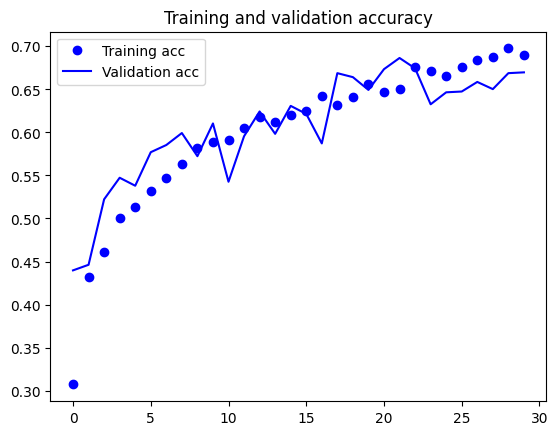

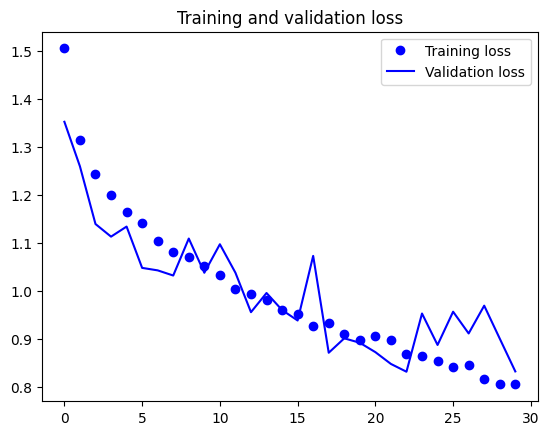

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Transfer learning

In [28]:
# Import model and its weights without top layers

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [29]:
# Add top layers

from keras import models
from keras import layers

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=2)

model.save('flowers_3.h5')

Found 2162 images belonging to 5 classes.
Found 1078 images belonging to 5 classes.
Epoch 1/30


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_35232\3738335654.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


108/108 - 14s - loss: 1.4206 - acc: 0.4288 - val_loss: 1.2002 - val_acc: 0.5928 - 14s/epoch - 132ms/step
Epoch 2/30
108/108 - 11s - loss: 1.0908 - acc: 0.6087 - val_loss: 1.0238 - val_acc: 0.6224 - 11s/epoch - 99ms/step
Epoch 3/30
108/108 - 11s - loss: 0.9536 - acc: 0.6628 - val_loss: 0.8904 - val_acc: 0.6985 - 11s/epoch - 100ms/step
Epoch 4/30
108/108 - 11s - loss: 0.8830 - acc: 0.6947 - val_loss: 0.8163 - val_acc: 0.7254 - 11s/epoch - 99ms/step
Epoch 5/30
108/108 - 11s - loss: 0.8414 - acc: 0.6896 - val_loss: 0.7854 - val_acc: 0.7226 - 11s/epoch - 100ms/step
Epoch 6/30
108/108 - 11s - loss: 0.7900 - acc: 0.7151 - val_loss: 0.7471 - val_acc: 0.7412 - 11s/epoch - 99ms/step
Epoch 7/30
108/108 - 11s - loss: 0.7612 - acc: 0.7308 - val_loss: 0.7163 - val_acc: 0.7449 - 11s/epoch - 99ms/step
Epoch 8/30
108/108 - 11s - loss: 0.7477 - acc: 0.7387 - val_loss: 0.7057 - val_acc: 0.7449 - 11s/epoch - 99ms/step
Epoch 9/30
108/108 - 11s - loss: 0.6966 - acc: 0.7604 - val_loss: 0.6821 - val_acc: 0.76

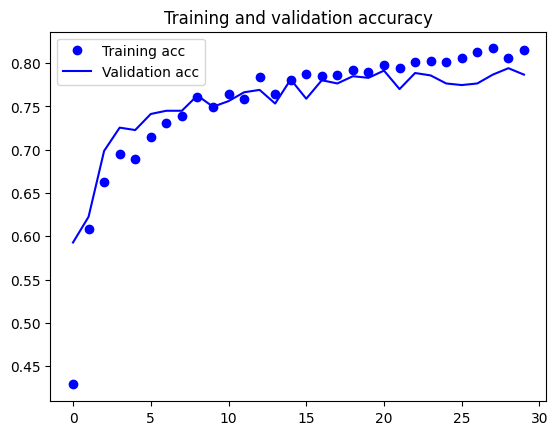

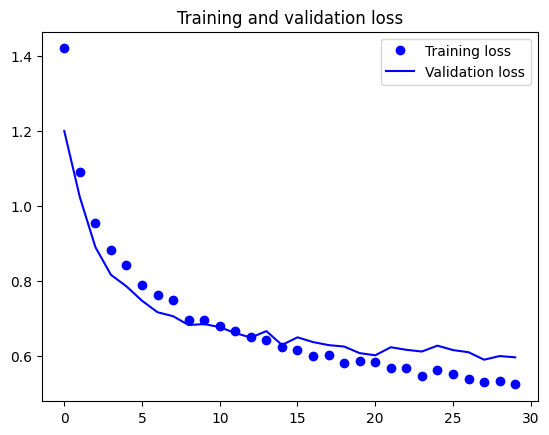

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tunning

In [33]:
# Set upper layers of the transfered model as trainable

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
# Compaile and fit a model with changes

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size)

model.save('flowers_4.h5')

Epoch 1/30


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_35232\1048769059.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


108/108 [==============================] - 12s 102ms/step - loss: 0.2431 - acc: 0.8062 - val_loss: 0.2125 - val_acc: 0.8052
Epoch 2/30
108/108 [==============================] - 11s 102ms/step - loss: 0.1961 - acc: 0.8168 - val_loss: 0.1970 - val_acc: 0.8247
Epoch 3/30
108/108 [==============================] - 11s 101ms/step - loss: 0.1723 - acc: 0.8437 - val_loss: 0.2000 - val_acc: 0.8265
Epoch 4/30
108/108 [==============================] - 11s 101ms/step - loss: 0.1665 - acc: 0.8437 - val_loss: 0.1849 - val_acc: 0.8154
Epoch 5/30
108/108 [==============================] - 11s 102ms/step - loss: 0.1562 - acc: 0.8612 - val_loss: 0.1930 - val_acc: 0.8228
Epoch 6/30
108/108 [==============================] - 11s 101ms/step - loss: 0.1433 - acc: 0.8779 - val_loss: 0.1748 - val_acc: 0.8349
Epoch 7/30
108/108 [==============================] - 11s 101ms/step - loss: 0.1369 - acc: 0.8774 - val_loss: 0.1714 - val_acc: 0.8275
Epoch 8/30
108/108 [==============================] - 11s 101ms/st

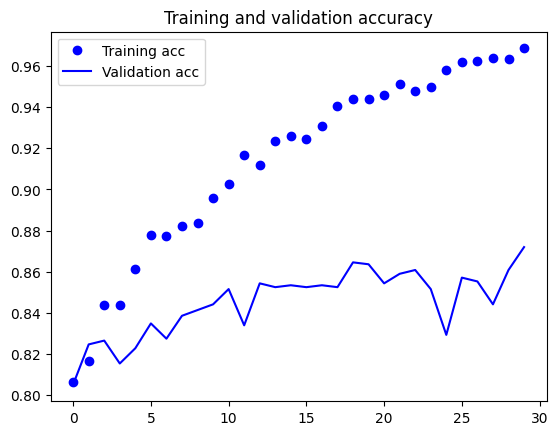

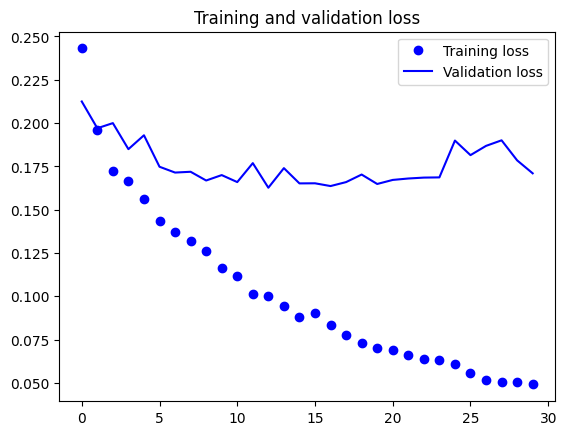

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 18ms/step
[[1. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 9ms/step
[[0. 1. 0. 0. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 0. 1. 0.]]
1/1 [==============================] - 0s 16ms/step
[[0. 0. 0. 0. 1.]]


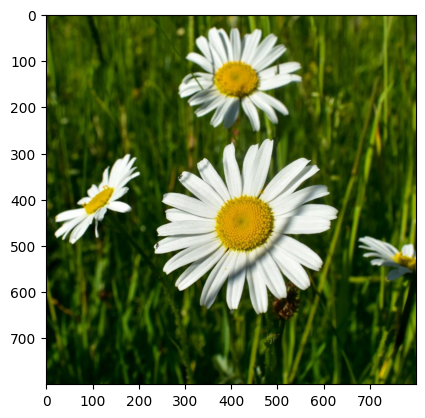

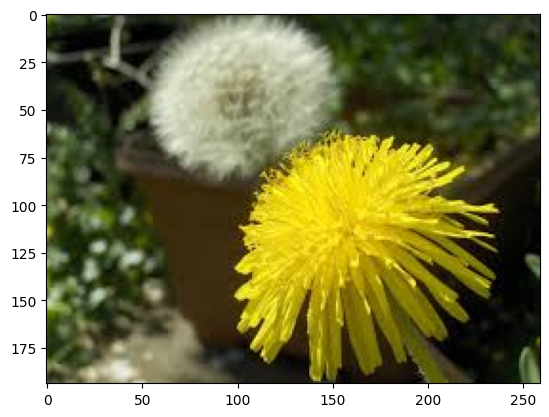

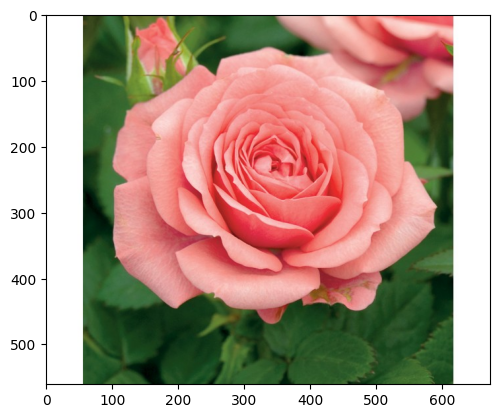

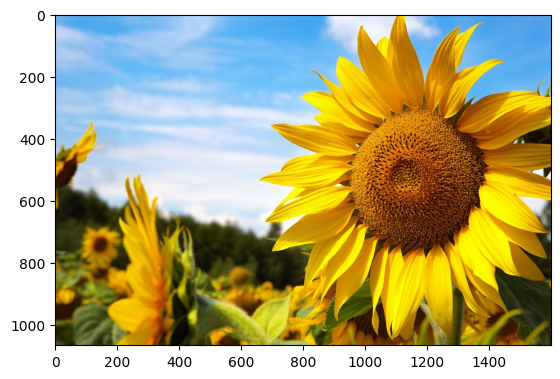

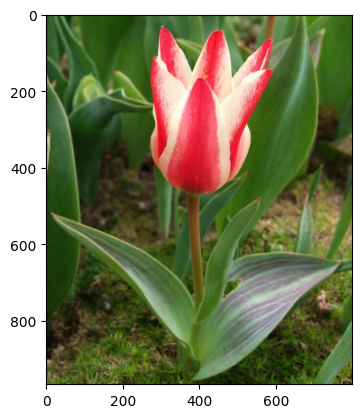

In [53]:
# Check what flower you have

urls=['https://meadowmania.co.uk/cdn/shop/files/Leucanthemumvulgare.jpg',
      'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTDaKmPIe8zAUcvD5N1h8knqWVVoe5BFApX6w&usqp=CAU',
      'https://florexpol.eu/19169-product_card_thumbnail/roza-wielkokwiatowa-katrin.jpg',
      'https://dietetycy.org.pl/wp-content/uploads/2021/05/15242820_m-1600x1067.jpg',
      'https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Tulipa_greigii_red-white_cultivar.jpg/800px-Tulipa_greigii_red-white_cultivar.jpg']

from PIL import Image
import requests
from io import BytesIO
import numpy as np

def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

for url in urls:
    img = load_image(url)
    plt.figure()
    plt.imshow(img)
    img = img.resize((150,150))
    x = image.img_to_array(img)
    # Reshape it to (1, 150, 150, 3) -> add batch dimension
    x = x.reshape((1,) + x.shape)

    # [daisy, dandelion, rose, sunflower, tulip]
    print(model.predict(x))
plt.show()